<a href="https://colab.research.google.com/github/SaranaSai/E-Waste-Classification-Model/blob/main/E_Waste_Final_Hybrid_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving E-Waste classification dataset.zip to E-Waste classification dataset.zip
Found 210 files belonging to 10 classes.
Found 40 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 655s 44s/step - accuracy: 0.1942 - loss: 2.6133 - val_accuracy: 0.7750 - val_loss: 1.4861 - learning_rate: 5.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 654s 46s/step - accuracy: 0.7194 - loss: 1.0254 - val_accuracy: 0.8750 - val_loss: 1.0495 - learning_rate: 5.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 671s 46s/step - accuracy: 0.9292 - loss: 0.5523 - val_accuracy: 0.8500 - val_loss: 0.8975 - learning_rate: 5.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 679s 45s/step - accuracy: 0.9395 - loss: 0.5311 - val_accuracy: 0.8500 - val_loss: 0.8263 - learning_rate: 5.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 636s 42s/step - accuracy: 0.9824 

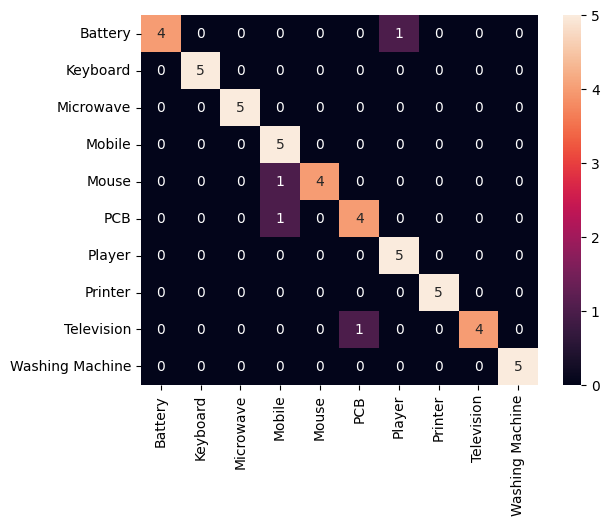

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0d6aa6e48db6735754.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
# ✅ ADVANCED E-WASTE CLASSIFIER USING TENSORFLOW/KERAS

# STEP 1: Install & Import Required Libraries
!pip install -q gradio

import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess_input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import gradio as gr
import zipfile, io, tempfile
from google.colab import files
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# --- Data Setup ---
def setup_dataset_for_second_cell():
    uploaded = files.upload()
    zip_path = list(uploaded.keys())[0]
    temp_unzip = "/content/uploaded_dataset_temp"
    base_path = "/content/modified-dataset"
    shutil.rmtree(temp_unzip, ignore_errors=True)
    shutil.rmtree(base_path, ignore_errors=True)
    os.makedirs(temp_unzip, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z: z.extractall(temp_unzip)
    # find class dirs
    class_dirs = [d for d,_,f in os.walk(temp_unzip) if any(f)]
    class_data = {os.path.basename(d): [os.path.join(d,f) for f in os.listdir(d) if f.lower().endswith(('jpg','png','jpeg'))] for d in class_dirs}
    train, val, test = os.path.join(base_path,'train'), os.path.join(base_path,'val'), os.path.join(base_path,'test')
    for p in (train,val,test): shutil.rmtree(p, ignore_errors=True); os.makedirs(p,exist_ok=True)
    for cls, imgs in class_data.items():
        tr, tmp = train_test_split(imgs, test_size=0.3, random_state=42)
        va, te = train_test_split(tmp, test_size=0.5, random_state=42)
        for path, subset in [(train,tr),(val,va),(test,te)]:
            dst = os.path.join(path,cls); os.makedirs(dst, exist_ok=True)
            for img in subset: shutil.copy(img, dst)
    shutil.rmtree(temp_unzip)
    return train, val, test

train_path, val_path, test_path = setup_dataset_for_second_cell()

# STEP 2: Load Data
IMAGE_SIZE=(240,240)
BATCH_SIZE=16  # smaller batch for more updates
augment_layer = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.05)
])

datasets_loaded=False
if all(os.path.exists(p) for p in (train_path,val_path,test_path)):
    AUTOTUNE=tf.data.AUTOTUNE
    datatrain = image_dataset_from_directory(train_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
    dataval   = image_dataset_from_directory(val_path,   image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
    datatest  = image_dataset_from_directory(test_path,  image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
    class_names = datatrain.class_names
    NUM_CLASSES = len(class_names)
    datatrain=datatrain.map(lambda x,y:(convnext_preprocess_input(x),y), num_parallel_calls=AUTOTUNE)
    datatrain=datatrain.map(lambda x,y:(augment_layer(x, training=True),y), num_parallel_calls=AUTOTUNE)
    datatrain=datatrain.cache().shuffle(1000).prefetch(AUTOTUNE)
    dataval=dataval.map(lambda x,y:(convnext_preprocess_input(x),y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    datatest=datatest.map(lambda x,y:(convnext_preprocess_input(x),y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    datasets_loaded=True

if datasets_loaded:
    # STEP 3: Build Hybrid Model
    convnext_base = ConvNeXtTiny(include_top=False, input_shape=(*IMAGE_SIZE,3), weights='imagenet')
    eff_base = tf.keras.applications.EfficientNetV2B1(include_top=False, input_shape=(*IMAGE_SIZE,3), weights='imagenet')
    convnext_base.trainable=False
    eff_base.trainable=False
    inp = layers.Input(shape=(*IMAGE_SIZE,3))
    x1 = convnext_base(inp); x1=layers.GlobalAveragePooling2D()(x1)
    x2 = eff_base(inp);     x2=layers.GlobalAveragePooling2D()(x2)
    merged = layers.Concatenate()([x1,x2])
    # Enhanced Head
    y = layers.BatchNormalization()(merged)
    y = layers.Dropout(0.3)(y)
    y = layers.Dense(128, activation='relu')(y)
    y = layers.Dropout(0.3)(y)
    out=layers.Dense(NUM_CLASSES, activation='softmax')(y)
    model = models.Model(inp,out)
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                  metrics=['accuracy'])
    # Callbacks
    cb = [callbacks.EarlyStopping('val_loss',patience=7,restore_best_weights=True),
          callbacks.ReduceLROnPlateau('val_loss',factor=0.2,patience=4,min_lr=1e-6),
          callbacks.ModelCheckpoint('best_model.keras',save_best_only=True,monitor='val_accuracy')]
    # Compute class weights
    labels=[]
    for _,y in datatrain.unbatch(): labels.append(np.argmax(y.numpy()))
    cw = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    cw_dict = dict(enumerate(cw))
    # Train head
    history = model.fit(datatrain, validation_data=dataval, epochs=20, callbacks=cb, class_weight=cw_dict)
    model = tf.keras.models.load_model('best_model.keras')
    # Partial Fine-tuning
    convnext_base.trainable=True; eff_base.trainable=True
    for layer in convnext_base.layers[:len(convnext_base.layers)//2]: layer.trainable=False
    for layer in eff_base.layers[:len(eff_base.layers)//2]: layer.trainable=False
    model.compile(optimizer=tf.keras.optimizers.AdamW(1e-5),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                  metrics=['accuracy'])
    history_ft = model.fit(datatrain, validation_data=dataval, epochs=28, initial_epoch=history.epoch[-1]+1, callbacks=cb, class_weight=cw_dict)

    # STEP 7: Evaluation
    preds,labels=[],[]
    for images, labs in datatest:
        p = model.predict(images); preds.extend(np.argmax(p,axis=1)); labels.extend(np.argmax(labs.numpy(),axis=1))
    print(classification_report(labels,preds,target_names=class_names))
    cm=confusion_matrix(labels,preds)
    sns.heatmap(cm,annot=True,xticklabels=class_names,yticklabels=class_names)
    plt.show()

   # STEP 8: Gradio Interface
TEMPERATURE = 0.5

def process_image_for_gradio(img_pil, w, h, model, class_names):
    img = img_pil.convert('RGB').resize((w, h))
    arr = tf.expand_dims(tf.keras.utils.img_to_array(img), 0)
    arr = convnext_preprocess_input(arr)
    logits = model.predict(arr)[0] / TEMPERATURE
    probs = tf.nn.softmax(logits).numpy()
    return {class_names[i]: round(float(probs[i]), 4) for i in range(len(class_names))}

def classify_upload(f):
    rows = []
    if zipfile.is_zipfile(f.name):
        with zipfile.ZipFile(f.name) as z:
            for e in z.namelist():
                if not e.lower().endswith(('.jpg', '.png', '.jpeg')):
                    continue
                img = Image.open(io.BytesIO(z.read(e)))
                res = process_image_for_gradio(img, IMAGE_SIZE[1], IMAGE_SIZE[0], model, class_names)
                top = max(res, key=res.get)
                rows.append((e, top))
    else:
        img = Image.open(f.name)
        res = process_image_for_gradio(img, IMAGE_SIZE[1], IMAGE_SIZE[0], model, class_names)
        top = max(res, key=res.get)
        rows.append((os.path.basename(f.name), top))

    df = pd.DataFrame(rows, columns=['Filename', 'Prediction'])
    path = tempfile.mktemp('.csv')
    df.to_csv(path, index=False)
    return df, path

gr.Interface(
    fn=classify_upload,
    inputs=gr.File(file_types=['.zip', '.jpg', '.png', '.jpeg']),
    outputs=[gr.Dataframe(), gr.File(label='Download')],
    title='E-Waste Image Classifier'
).launch(share=True)
